In [ ]:
!pip install tiktoken

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, tiktoken, eli5, nltk

from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

pd.set_option('display.max_colwidth', None)

2024-05-17 17:53:40.447300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 17:53:40.447420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 17:53:40.566298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Pré-traitement

## Unifier les datasets

In [7]:
df = pd.read_csv("/kaggle/input/final-dataset/final_lemm.csv")
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

print(f"Numbers of poems: {len(df)}")
df.tail()

Numbers of poems: 10037


,poem,topic
10032,light go go rtling grass fall convention good grace learn some filing file writing writ demonstrating cutlery selling knowledge door door some might even drop lovely life factory derting ring coolantspouting turntable vertical lathe best every know generally thought general knowledge find pool room roadside bar meadow inviting bed bedroom whisper ribbon untying even find school careful dangero inescapable exact every atom everything every name thing go every law thing obeys best part always know know,arts&sciences
10033,isnt moon dark time doesnt white page seem unfinished without dark stain alphabet god demanded light didnt banish darkness instead invented ebony crow small mole left cheekb mean ask sad often ask moon ask witnessed,arts&sciences
10034,imagined atmosphere would clear shot pristine light sulphuro haze air ionized thunderstorm many pictured river mentid boat bench crowded naked passenger bent writing tablet knew would always child model train model tunnel knew would live forever jumping day hoop heard journey side clink final coin leather purse man holding oar could any guessed soon arrived would asked describe place include much detail possible water insists rather oily fathomless rathappy water simply shackle rty iron ankleshredding shackle next assignment would jot top head thought feeling dead really assignment man rotating oar keep telling think exercise groan think writing process neverending infernal process boat become jammed together bow stern stern locked bow thing moving diligent pen,arts&sciences
10035,miss nancy ellicott strode across hill broke rode across hill broke them barren new england hill riding hound cowpasture miss nancy ellicott smoked danced modern dance aunt quite sure felt knew modern upon glazen shelf kept watch matthew waldo guardian faith army unalterable law,arts&sciences
10036,dark disappear pure mirror image impure becoming heidegger nothingness sartre which purer al way th lliness test pure night love fell far quite far enough pure impure cloud snow mist dragon breath water smoke fire metaphor pure stillness stillness light locked deep inside both pure impure verb noun pronoun purist looked within saw nothing clearly purest,arts&sciences


nb poems in topics: 10037


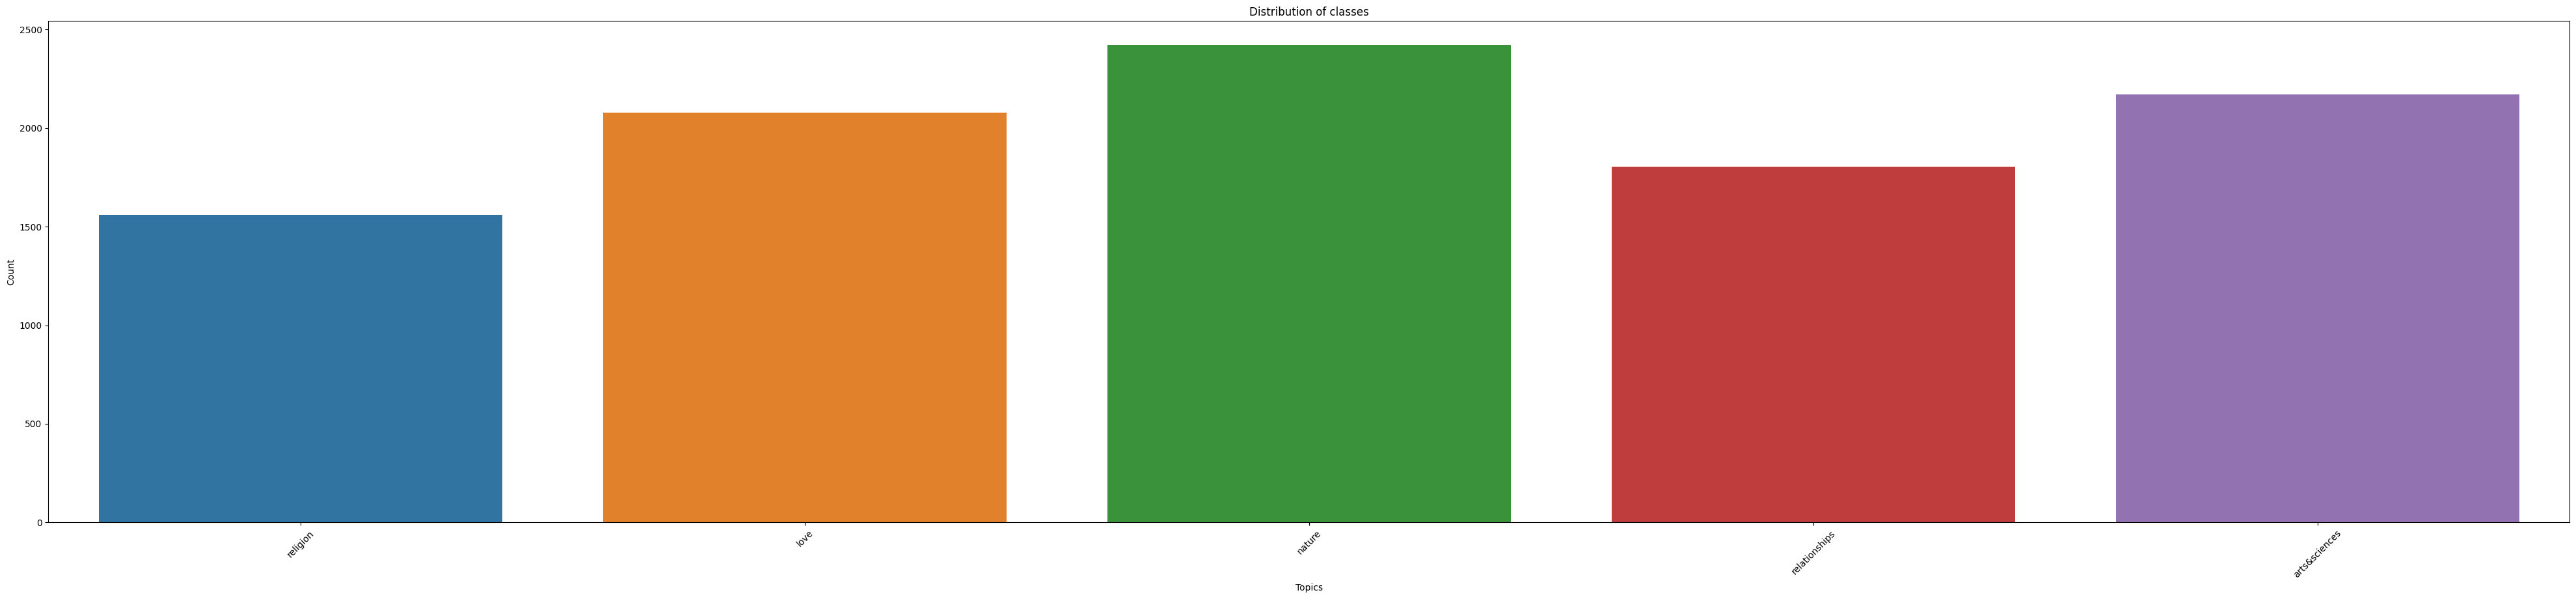

In [8]:
print(f"nb poems in topics: {len(df)}")
#print(f"nb poems in poetry foundation: {len(df_PoetryFoundationData)}")

plt.figure(figsize=(50, 10))
sns.countplot(x='topic', data=df)
plt.title('Distribution of classes') 
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Model & Fitting

In [9]:
X = df['poem']
y = df['topic']

label_encoder = LabelEncoder()
classes = np.array(y.values)

integer_encoded = label_encoder.fit_transform(classes) # Transform classes to integers

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(integer_encoded, dtype=torch.long)

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class MultiLayerPerceptron2(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron2, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim*2)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)
    
class MultiLayerPerceptron3(nn.Module):
    def __init__(self, vocab_size, hidden_dim, num_classes):
        super(MultiLayerPerceptron3, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dim * 2)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout1 = nn.Dropout(p=0.4)
        
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(p=0.2)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout3 = nn.Dropout(p=0.1)
        
        self.fc4 = nn.Linear(hidden_dim // 2, num_classes)
    
    def forward(self, x):
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.fc4(x)

In [35]:
num_epochs = 10
vocab_size = X_tensor.shape[1]
num_classes = len(set(y.values))

model = MultiLayerPerceptron3(vocab_size, 16, num_classes)
print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

def smooth_labels(labels, smoothing, num_classes):
    with torch.no_grad():
        labels = labels * (1 - smoothing) + smoothing / num_classes
    return labels

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.long()
        
        # Forward pass
        outputs = model(inputs)
        
        # Label smoothing
        labels = smooth_labels(F.one_hot(labels, num_classes).float(), 0.02, num_classes)
        
        # Loss
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels)
            all_predictions.extend(predicted)

    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

MultiLayerPerceptron3(
  (fc1): Linear(in_features=108076, out_features=32, bias=True)
  (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (batch_norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (batch_norm3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=8, out_features=5, bias=True)
)
Epoch [1/10], Loss: 1.5902
Precision: 0.2752, Recall: 0.2375, F1 Score: 0.1614
Epoch [2/10], Loss: 1.4298
Precision: 0.3663, Recall: 0.3690, F1 Score: 0.3661
Epoch [3/10], Loss: 0.8867
Precision: 0.4380, Recall: 0.4119, F1 Score: 0.4151
Epoch [4/10], Loss: 0.5092
Precision: 0.4698, Recall: 0.4213, F1 Score: 0.4

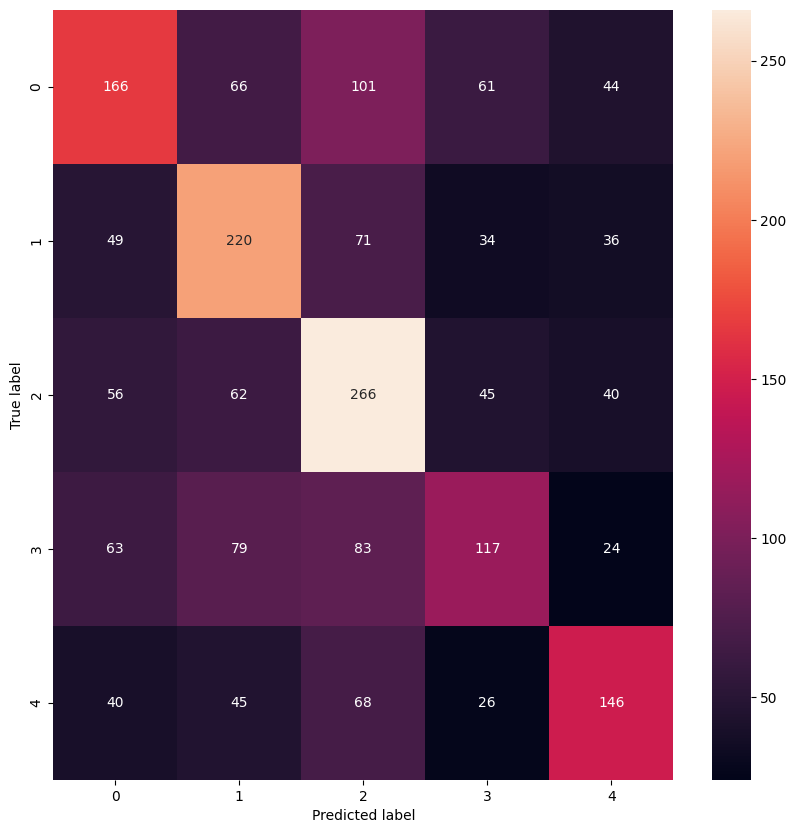

In [36]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [18]:
class_names = list(set(y.values))
report = classification_report(all_labels, all_predictions, target_names=class_names)

accuracy = accuracy_score(all_labels, all_predictions)

print("Score de précision :", accuracy)
print("Rapport de classification :\n", report)

Score de précision : 0.5047193243914555
Rapport de classification :
                precision    recall  f1-score   support

relationships       0.47      0.51      0.49       453
arts&sciences       0.55      0.50      0.52       394
       nature       0.50      0.64      0.56       490
         love       0.45      0.41      0.43       348
     religion       0.62      0.40      0.49       328

     accuracy                           0.50      2013
    macro avg       0.52      0.49      0.50      2013
 weighted avg       0.51      0.50      0.50      2013

